# Wstęp

### Cel i zakres badania
Celem niniejszej pracy jest analiza popytu na mięso wieprzowe w Polsce w latach 2010–2022 przy użyciu modeli ekonometrycznych. W szczególności badaniu podlegać będzie:
1. **Estymacja elastyczności dochodowej** – oszacowanie wpływu dochodu na poziom konsumpcji wieprzowiny na osobę.
2. **Porównanie trzech funkcji popytu** – wykładniczej, potęgowej oraz funkcji Tornquista I rzędu.
3. **Ocena dopasowania modeli i interpretacja wyników** – wybór najlepszego modelu oraz wyciągnięcie wniosków dotyczących reakcji konsumpcji na zmiany dochodów.

### Metodologia i źródła danych

Analiza bazuje na danych rocznych dla Polski za lata 2010–2022, obejmujących:

- `consumption_per_capita` – roczne spożycie mięsa wieprzowego na osobę [kg/os],
- `income` – przeciętny miesięczny dochód brutto [PLN],

Źródła danych:
- Główny Urząd Statystyczny (GUS)
    - [Przeciętne wynagrodzenie brutto](https://bdl.stat.gov.pl/bdl/metadane/cechy/2497?back=True)
    - [Ludność w Polsce](https://bdl.stat.gov.pl/bdl/metadane/podgrupy/7?back=True)
- Food and Agriculture Organization of the United Nations (FAO):
    - [Roczne spożycie wieprzowiny](https://www.fao.org/faostat/en/#data/FBS?countries=173&elements=2141&items=2733&years=2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022&output_type=table&file_type=csv&submit=true)

W analizie zastosowano trzy podejścia modelowe:

- **Model wykładniczy**
- **Model potęgowy**
- **Model Tornquista I rzędu**

Dopasowanie modeli oceniono na podstawie współczynnika determinacji $R^2$, błędów prognozy (MAPE, MAE) oraz istotności parametrów.

### Struktura pracy

Niniejszy projekt został podzielony na trzy główne części:

1. **Wstęp** – prezentacja tematu, celu badania, danych oraz metodologii.
2. **Część obliczeniowa** – estymacja trzech modeli ekonometrycznych oraz interpretacja uzyskanych wyników.
3. **Wnioski końcowe** – analiza uzyskanych rezultatów i porównanie modeli.

In [334]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import random
from scipy.optimize import curve_fit
import warnings
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'DejaVu Sans'

warnings.filterwarnings('ignore')

In [335]:
def exponential_model(x, a, b):
    return np.exp(a + b / x)

def power_model(x, a, b):
    return a * (x ** b)

def tornquist_model(x, a, b):
    return (a * x) / (x + b)

def elasticity_exponential(x, b):
    return -b / x

def elasticity_power(x, b):
    return b

def elasticity_tornquist(x, b):
    return b / (b + x)

def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"R² = {r2:.4f}, MAPE = {mape:.4f}, MAE = {mae:.4f}")

def evaluate_parameters(popt, pcov, model_name):
    se = np.sqrt(np.diag(pcov))
    t_values = popt / se
    df = len(x) - len(popt)
    p_values = [2 * (1 - stats.t.cdf(np.abs(t), df)) for t in t_values]
    
    print(f"\n{model_name}:")
    for i, (param, stderr, t, p) in enumerate(zip(popt, se, t_values, p_values)):
        print(f"Parametr {'a' if i == 0 else 'b'}:")
        print(f"  Wartość     = {param:.4f}")
        print(f"  Std. błąd   = {stderr:.4f}")
        print(f"  t-stat      = {t:.4f}")
        print(f"  p-value     = {p:.4f}")
        
def model_plot(x, y, model_func, model_params, model_name, color):
    x_range_extended = np.linspace(0, x.max() * 1.1, 200)
    y_model = model_func(x_range_extended, *model_params)

    plt.figure(figsize=(8, 5))
    plt.scatter(x, y, color='black', label='Rzeczywiste')
    plt.plot(x_range_extended, y_model, label='Model', linestyle='-', color=color)
    plt.xlabel("Dochód (PLN)")
    plt.ylabel("Konsumpcja [kg/os]")
    plt.title(model_name)
    plt.legend()
    plt.grid(True)
    plt.show()

In [336]:
df = pd.read_csv('source/data.csv', sep=',', encoding='utf-8')

x = df["income"].values
y = df["consumption_per_capita"].values
x_range = np.linspace(x.min(), x.max(), 100)

In [337]:
print("Struktura wczytanego zbioru danych:")
print(df.head())

print("\nInformacje o zbiorze danych:")
print(df.info())

print("\nLiczba braków danych w każdej kolumnie:")
print(df.isnull().sum())

df = df.dropna()

Struktura wczytanego zbioru danych:
   year  consumption_per_capita   income
0  2010               52.712356  3435.00
1  2011               53.193633  3625.21
2  2012               49.230148  3744.38
3  2013               46.083118  3877.43
4  2014               50.417632  4003.99

Informacje o zbiorze danych:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    13 non-null     int64  
 1   consumption_per_capita  13 non-null     float64
 2   income                  13 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 444.0 bytes
None

Liczba braków danych w każdej kolumnie:
year                      0
consumption_per_capita    0
income                    0
dtype: int64


In [338]:
print("\nStatystyki opisowe:")
display(df.drop(columns=['year']).describe())


Statystyki opisowe:


,consumption_per_capita,income
count,13.000000,13.000000
mean,53.113435,4607.817692
std,3.089783,994.199408
min,46.083118,3435.000000
25%,52.712356,3877.430000
50%,53.573763,4290.520000
75%,54.519467,5181.630000
max,57.665551,6705.620000



Model wykładniczy:
Parametr a:
  Wartość     = 4.1498
  Std. błąd   = 0.0719
  t-stat      = 57.7280
  p-value     = 0.0000
Parametr b:
  Wartość     = -788.5488
  Std. błąd   = 316.9266
  t-stat      = -2.4881
  p-value     = 0.0301
R² = 0.3587, MAPE = 0.0375, MAE = 1.9457
E(3435.00) = 0.2296
E(3625.21) = 0.2175
E(3744.38) = 0.2106
E(3877.43) = 0.2034
E(4003.99) = 0.1969
E(4150.86) = 0.1900
E(4290.52) = 0.1838
E(4527.89) = 0.1742
E(4834.76) = 0.1631
E(5181.63) = 0.1522
E(5523.32) = 0.1428
E(6001.02) = 0.1314
E(6705.62) = 0.1176

Przy zarobkach na poziomie 4003.99 PLN rocznie, wzrost dochodu o 1% powoduje zwiększenie konsumpcji mięsa wieprzowego o średnio 19.69%.


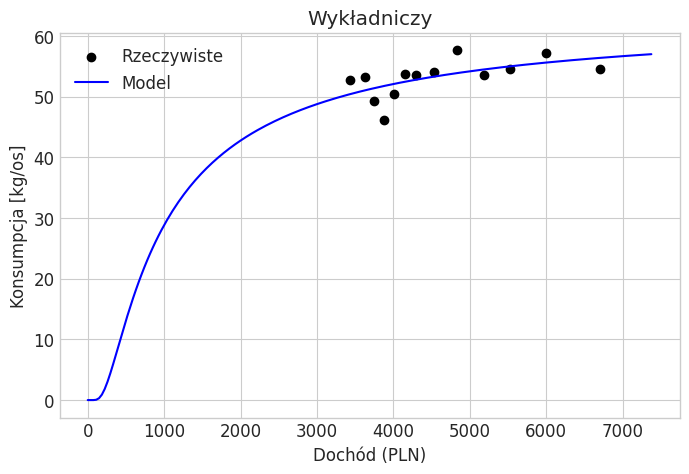

In [339]:
params_exp, pcov_exp = curve_fit(exponential_model, x, y)
y_pred_exp = exponential_model(x, *params_exp)
y_plot_exp = exponential_model(x_range, *params_exp)

evaluate_parameters(params_exp, pcov_exp, "Model wykładniczy")
evaluate_model(y, y_pred_exp, "Model wykładniczy")
e_exponential = elasticity_exponential(x, params_exp[1])
idx = random.randint(0, len(e_exponential) - 1)

for xi, ei in zip(x, e_exponential):
    print(f"E({xi:.2f}) = {ei:.4f}")

print(f"\nPrzy zarobkach na poziomie {x[idx]:.2f} PLN rocznie, "
      f"wzrost dochodu o 1% powoduje zwiększenie konsumpcji mięsa wieprzowego o średnio {e_exponential[idx]:.2%}.")

model_plot(x, y, exponential_model, params_exp, model_name="Wykładniczy", color="blue")


Model potęgowy:
Parametr a:
  Wartość     = 13.2704
  Std. błąd   = 7.5895
  t-stat      = 1.7485
  p-value     = 0.1082
Parametr b:
  Wartość     = 0.1647
  Std. błąd   = 0.0678
  t-stat      = 2.4285
  p-value     = 0.0335
R² = 0.3472, MAPE = 0.0377, MAE = 1.9564

Wzrost dochodu o 1% powoduje zwiększenie konsumpcji mięsa wieprzowego o średnio 16.47%


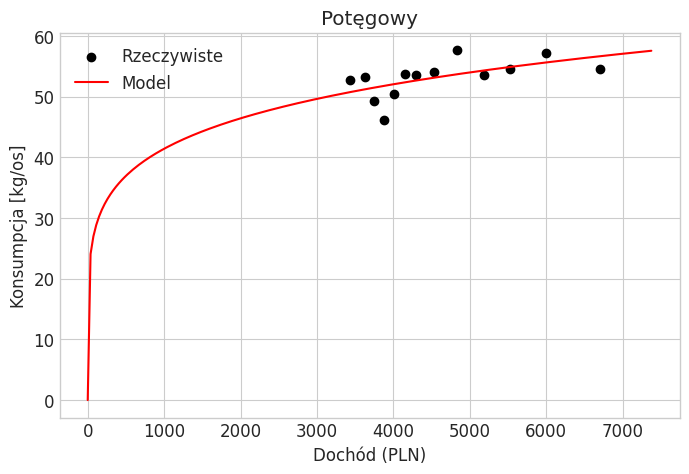

In [340]:
params_power, pcov_power = curve_fit(power_model, x, y)
y_pred_power = power_model(x, *params_power)
y_plot_power = power_model(x_range, *params_power)

evaluate_parameters(params_power, pcov_power, "Model potęgowy")
evaluate_model(y, y_pred_power, "Model potęgowy")
e_power = elasticity_power(x, params_power[1])

print(f"\nWzrost dochodu o 1% powoduje zwiększenie konsumpcji mięsa wieprzowego o średnio {e_power:.2%}")

model_plot(x, y, power_model, params_power, model_name="Potęgowy", color="red")


Model Tornquista:
Parametr a:
  Wartość     = 64.4141
  Std. błąd   = 5.5036
  t-stat      = 11.7039
  p-value     = 0.0000
Parametr b:
  Wartość     = 948.8905
  Std. błąd   = 461.1782
  t-stat      = 2.0575
  p-value     = 0.0641
R² = 0.3579, MAPE = 0.0376, MAE = 1.9472
E(3435.00) = 0.2164
E(3625.21) = 0.2074
E(3744.38) = 0.2022
E(3877.43) = 0.1966
E(4003.99) = 0.1916
E(4150.86) = 0.1861
E(4290.52) = 0.1811
E(4527.89) = 0.1733
E(4834.76) = 0.1641
E(5181.63) = 0.1548
E(5523.32) = 0.1466
E(6001.02) = 0.1365
E(6705.62) = 0.1240

Przy zarobkach na poziomie 4150.86 PLN rocznie, wzrost dochodu o 1% powoduje zwiększenie konsumpcji mięsa wieprzowego o średnio 18.61%.

Poziom nasycenia wynosi 64.41. Oznacza to że spożycie mięsa wieprzowego nie powinno przekroczyć 64 kg/osobę.


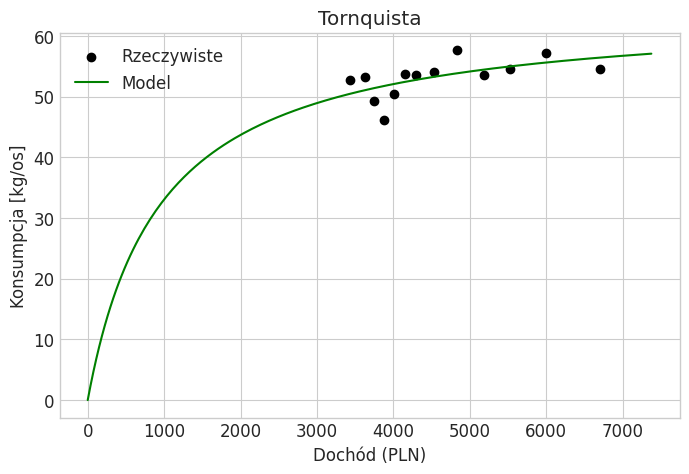

In [341]:
params_torn, pcov_torn = curve_fit(tornquist_model, x, y)
y_pred_torn = tornquist_model(x, *params_torn)
y_plot_torn = tornquist_model(x_range, *params_torn)

evaluate_parameters(params_torn, pcov_torn, "Model Tornquista")
evaluate_model(y, y_pred_torn, "Model Tornquista")

e_tornquist = elasticity_tornquist(x, params_torn[1])
idx = random.randint(0, len(e_tornquist) - 1)

for xi, ei in zip(x, e_tornquist):
    print(f"E({xi:.2f}) = {ei:.4f}")

print(f"\nPrzy zarobkach na poziomie {x[idx]:.2f} PLN rocznie, "
      f"wzrost dochodu o 1% powoduje zwiększenie konsumpcji mięsa wieprzowego o średnio {e_tornquist[idx]:.2%}.")

print(f"\nPoziom nasycenia wynosi {params_torn[0]:.2f}. "
      f"Oznacza to że spożycie mięsa wieprzowego nie powinno przekroczyć {params_torn[0]:.0f} kg/osobę.")

model_plot(x, y, tornquist_model, params_torn, model_name="Tornquista", color="green")

# Porównanie modeli popytu na mięso wieprzowe w Polsce (2010–2022)

| Model                  | $R^2$     	 | MAPE  	 | MAE    	 | Istotność `b`  	 |
|------------------------|-------------|---------|----------|------------------|
| **Wykładniczy**        | 0.3587 	    | 3.75% 	 | 1.9457	  | ✔ (p = 0.0301) 	 |
| **Potęgowy**           | 0.3472 	    | 3.77% 	 | 1.9564	  | ✔ (p = 0.0335) 	 |
| **Tornquista I rzędu** | 0.3579 	    | 3.76% 	 | 1.9472	  | (p = 0.0641)	    |


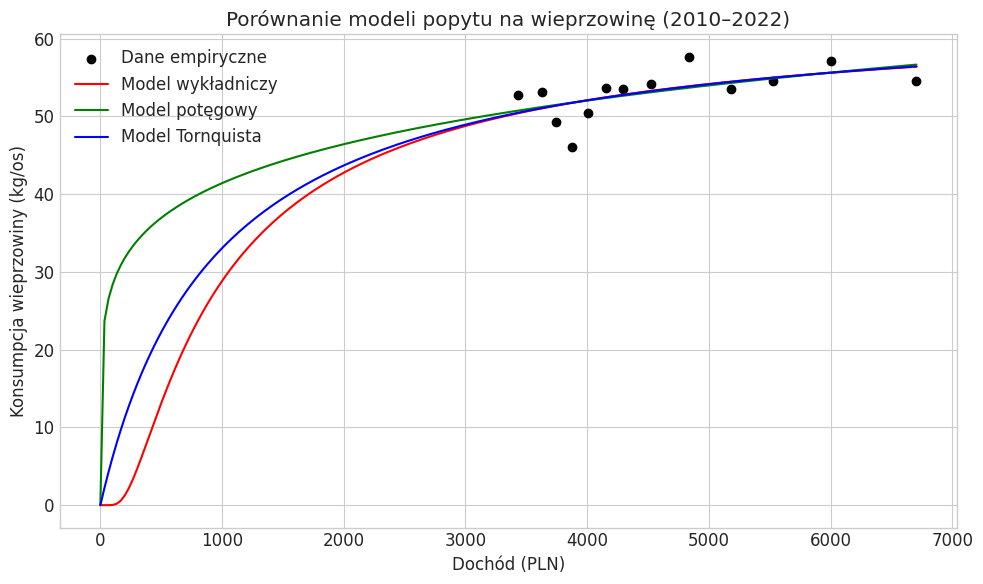

In [346]:
x_range = np.linspace(0, x.max(), 200)
# x_range = np.linspace(x.min(), x.max(), 200)
y_exp = exponential_model(x_range, *params_exp)
y_power = power_model(x_range, *params_power)
y_torn = tornquist_model(x_range, *params_torn)

plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='black', label='Dane empiryczne')
plt.plot(x_range, y_exp, label='Model wykładniczy', color='red')
plt.plot(x_range, y_power, label='Model potęgowy', color='green')
plt.plot(x_range, y_torn, label='Model Tornquista', color='blue')

plt.xlabel('Dochód (PLN)')
plt.ylabel('Konsumpcja wieprzowiny (kg/os)')
plt.title('Porównanie modeli popytu na wieprzowinę (2010–2022)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Podsumowanie
W niniejszej analizie porównano trzy nieliniowe modele opisujące zależność między dochodem, a konsumpcją mięsa wieprzowego w Polsce w latach 2010–2022. Wszystkie trzy modele osiągnęły bardzo zbliżony poziom dopasowania, z wartością współczynnika determinacji $R^2$ na poziomie około 0.35. Także pozostałe miary błędu — MAPE (3.75–3.77%) i MAE (~1.95 kg) — wskazują na zbliżoną precyzję prognoz między modelami.

Spośród analizowanych modeli za najbardziej trafny możemy uznać model Tornquista. Mimo iż nie osiągnął najwyższego $R^2$, najlepiej oddaje ekonomiczne mechanizmy stojące za decyzjami konsumpcyjnymi — w szczególności efekt nasycenia przy wyższych poziomach dochodu. Jego struktura pozwala na realistyczne prognozowanie zachowań konsumenckich w miarę wzrostu dobrobytu, co czyni go szczególnie użytecznym narzędziem w kontekście długookresowej analizy popytu.

Aby poprawić dopasowanie modeli, należałoby uwzględnić dodatkowe zmienne wyjaśniające, takie jak ceny mięsa, ceny dóbr substytucyjnych (np. drobiu lub wołowiny), lub trendy demograficzne. Ujęcie wpływu inflacji oraz zmian preferencji konsumenckich mogłoby również zwiększyć precyzję prognoz.